# Compact Cart Pole
# Homework 03 - Deep Reinforcement Learning
*Neural Networks and Deep Learning* 
*Lecture by Prof. Alberto Testolin*\
*@ the University of Padova* \
*Winter term 2021/22* \

*Nathanael Schmidt-Ott* \
*Master student in Applied Statistics* \
*@ Göttingen University* \
*Guest Student at the univeristy of padova* 
 
ursnathanael.schmidtott@studenti.unipd.it


In [ ]:
# mount drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# % cd /content/gdrive/MyDrive/NNDL_PD/HW_3/

import os 
if not os.path.isdir("plots"):
  os.makedirs("plots")

if not os.path.isdir("models"):
  os.makedirs("models")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/NNDL_PD/HW_3


# Load packages
And install needed packages as well as introduce a screen to colab.

In [ ]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import torch
import numpy as np
import pandas as pd
import os 
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle 
!pip install optuna
import optuna
from optuna.trial import TrialState

from torch import nn
from collections import deque

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-upda

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience Replay
initialise the expercience replay buffer to store (s,a,r,s') tuples. In practice the buffer has limited capacity and the oldest episodes are removed from the buffer whenever the storage capacitiy is exhausted.

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(5, 5, 5, 5), (4, 4, 4, 4)]


# Define the policy network (i.e. the prediction network)
This network is updated at every training iteration and takes the current state as input and outputs the q-value for every action in the action space A. I define this network as a simple feed forward network consisting of two fully connected layers and a ReLU activation function.

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features = state_space_dim,
                         out_features = 128),
            nn.Tanh(),
            nn.Linear(128,128),
            nn.Tanh(),
            nn.Linear(in_features = 128,
                      out_features = action_space_dim)
            )

    def forward(self, x):
        return self.linear(x)

# Action policies
The temperature for softmax or epsilon for epsilon-greedy policy govern how random the decision of the action is. It is sensible to introduce a higher temperature at the beginning enforcing greater exploration and decaying it.

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# state = (0, 0, 0, 0)
# epsilon = .5
# chosen_action, q_values = choose_action_epsilon_greedy(dqn, state, epsilon)

# print(f"ACTION: {chosen_action}")
# print(f"Q-VALUES: {q_values}")
# print("since epsilon = 0.5, it sometimes chooses the action associated with the highest q-value and with 50% the other option.")
# print('epsilon = 0 would always yield the action resulting in the highest q-value.')

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
# state = (0, 0, 0, 0)
# temperature = 1
# chosen_action, q_values = choose_action_softmax(dqn, state, temperature)

# print(f"ACTION: {chosen_action}")
# print(f"Q-VALUES: {q_values}")

In [ ]:
### Define exploration profile
class Exploration_profile():
  def __init__(self, initial_value, num_iterations, expl_type = 'soft', decay_speed = 6):
    profile = list(map(lambda i : initial_value*np.exp(-i*decay_speed*np.log(10)/num_iterations), np.arange(0,num_iterations)))
    self.profile = np.array(profile)
    if expl_type == 'soft':
      self.expl_type = choose_action_softmax
    else:
      self.expl_type = choose_action_epsilon_greedy

  def plot_profile(self, path = None):
    plt.figure(figsize = (6,6))
    plt.plot(self.profile)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter')
    plt.rcParams.update({'font.size': 14})
    plt.tight_layout()
    if path is not None:
      plt.savefig(path, dpi = 300, bbox_inches='tight')
    plt.show()

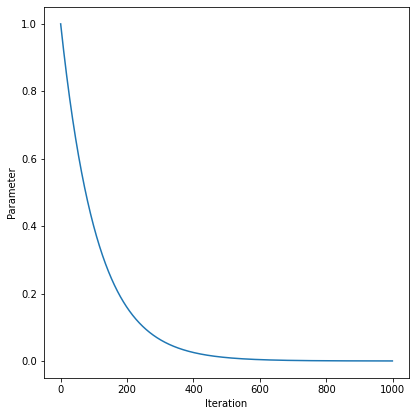

In [ ]:
exemplary_epsilon_greedy_profile = Exploration_profile(1,1000,expl_type = 'eps_greedy', decay_speed = 4)
exemplary_epsilon_greedy_profile.plot_profile(path = 'plots/exemplary_profile.png')

# The CartPole game

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(2909) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


# Define training functions
Below I define the functions needed to train the network.

In [ ]:
# define the update step to update the policy and the networks
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # At each game period, the training data is a sample from the replay memory
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size) # sample batch_size states from the replay memory
    batch_size = len(batch)

    # the replay memory consists of tuples (s,a,s',r) (state, action, new_state, reward)

    # Create tensors for each element of the batch
    states      = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32)
    actions     = torch.tensor(np.array([s[1] for s in batch]), dtype=torch.int64)
    rewards     = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states) # for each state in the batch compute the current q-value
    # Select the proper Q value for the corresponding action taken Q(s_t, a_t)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
# define the training wrapper function

def run_training(exploration_profile, policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, pos_weight = 0):

  # Initialize the Gym environment
  env = gym.make('CartPole-v1') 
  env.seed(2909)

  # This is for creating the output video in Colab, not required outside Colab
  #env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
  
  episode_scores = []
  episode_rewards = []
  episode_qvals = []
  episode_frames = []
  
  for episode_num, tau in enumerate(tqdm(exploration_profile.profile)):
      # episode_num is the number of total games decided by the exploration profile
      # Reset the environment and get the initial state
      state = env.reset()
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False
      rewards = []
      q_vals = []

      # store the sequence of images for the 10th and the last episode
      if episode_num == 9 or episode_num == len(exploration_profile.profile) - 1:
          save_frames = []
          frame = env.render('rbg_array')
          save_frames.append(frame)


      while not done:
        # just play the game, i.e. take a step forward using whatever policy decided.

        # Choose the action following the policy
        action, q_values = exploration_profile.expl_type(policy_net, state, tau)
        
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        
        # if in 10th or last episode save the corresponding frame
        if episode_num == 9 or episode_num == len(exploration_profile.profile) - 1:
            next_frame = env.render('rgb_array')
            save_frames.append(next_frame)

        # We apply a (linear) penalty when the cart is far from center
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)
        rewards.append(reward)
        q_vals.append(q_values[action])

        # Update the network (i.e. train the policy network)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Set the current state for the next iteration
        state = next_state

      # Update the target network every target_net_update_steps episodes
      if episode_num % target_net_update_steps == 0:
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # add the final score to the output list
      episode_scores.append(score)
      episode_rewards.append(np.mean(rewards))
      episode_qvals.append(np.mean(q_vals))
      if episode_num == 9 or episode_num == len(exploration_profile.profile) - 1:
        episode_frames.append(save_frames)
      
  env.close()
  return episode_scores, episode_rewards, episode_qvals, episode_frames
  

# Compare different action policies

## Train models

In [ ]:
# function to initialise networks
def initialise_networks():
  replay_mem = ReplayMemory(replay_memory_capacity) 
  policy_net = DQN(state_space_dim, action_space_dim)
  target_net = DQN(state_space_dim, action_space_dim)
  target_net.load_state_dict(policy_net.state_dict()) 
  sgd = torch.optim.SGD(policy_net.parameters(), lr = lr)
  huber = nn.SmoothL1Loss()
  return replay_mem, policy_net, target_net, sgd, huber

In [ ]:
# Set random seeds
torch.manual_seed(2909)
np.random.seed(2909)
random.seed(2909)

### PARAMETERS
n_episodes = 2000
gamma = 0.97   # gamma parameter for the long term reward (dicount factor)
replay_memory_capacity = 10000   # Replay memory capacity (storage)
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = -5   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

### Initialise exploration profiles
soft = Exploration_profile(5,n_episodes,'soft', decay_speed = 4)
eps_greedy = Exploration_profile(1,n_episodes,'eps_greedy', decay_speed = 4)
max_greedy = Exploration_profile(0,n_episodes,'max_greedy')

### Run training
replay_mem, policy_net, target_net, sgd, huber = initialise_networks()
max_res = run_training(max_greedy, policy_net, target_net, replay_mem, gamma, sgd, huber, batch_size)

replay_mem, policy_net, target_net, sgd, huber = initialise_networks()
soft_res = run_training(soft, policy_net, target_net, replay_mem, gamma, sgd, huber, batch_size)

replay_mem, policy_net, target_net, sgd, huber = initialise_networks()
eps_res = run_training(eps_greedy, policy_net, target_net, replay_mem, gamma, sgd, huber, batch_size)

100%|██████████| 2000/2000 [29:24<00:00,  1.13it/s]


In [ ]:
res = [max_res,soft_res,eps_res]
# store results
with open("models/cart_pole_res.pickle",'wb') as f:
  pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)

## plot results

In [ ]:
# make plots
with open("models/cart_pole_res.pickle",'rb') as f:
  max_res,soft_res,eps_res = pickle.load(f)

def mvg_avg(score_list, res = 100):
  avg = []
  for i in range(len(score_list)):
    avg.append(np.mean(score_list[i:i+res]))
    if i + res == len(score_list):
      break
  episode_number = np.arange(res,len(score_list)+1,1)
  out = [episode_number, avg]
  return np.array(out)

In [ ]:
test = mvg_avg(max_res[0],100)
test.shape

(2, 1901)

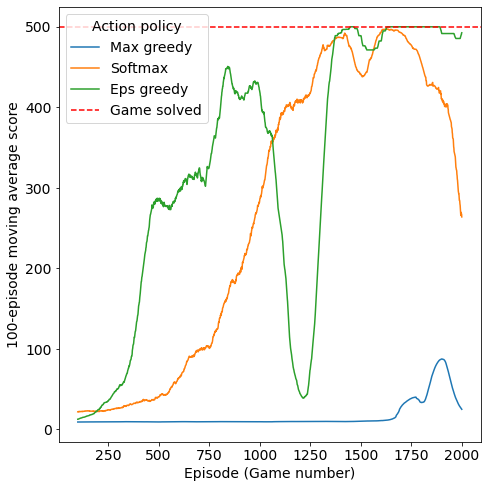

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(mvg_avg(max_res[0],100)[0],mvg_avg(max_res[0],100)[1], label = "Max greedy")
plt.plot(mvg_avg(soft_res[0],100)[0],mvg_avg(soft_res[0],100)[1], label = "Softmax")
plt.plot(mvg_avg(eps_res[0],100)[0],mvg_avg(eps_res[0],100)[1], label = "Eps greedy")
plt.axhline(y = 500, label = "Game solved", color = 'red', linestyle = 'dashed')
plt.xlabel("Episode (Game number)")
plt.ylabel("100-episode moving average score")
plt.legend(title = 'Action policy')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("plots/cart_pole_scores.png",dpi = 300, bbox_inches='tight')
plt.show()

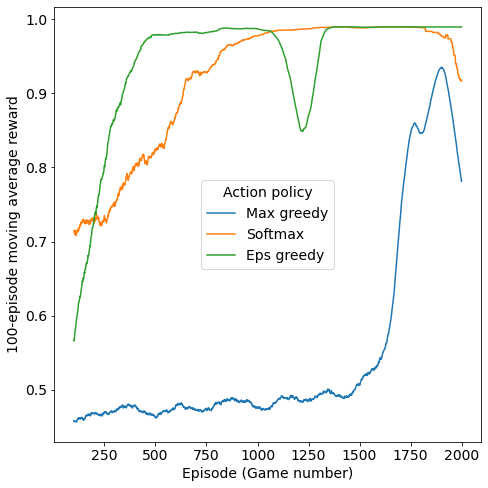

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(mvg_avg(max_res[1],100)[0],mvg_avg(max_res[1],100)[1], label = "Max greedy")
plt.plot(mvg_avg(soft_res[1],100)[0],mvg_avg(soft_res[1],100)[1], label = "Softmax")
plt.plot(mvg_avg(eps_res[1],100)[0],mvg_avg(eps_res[1],100)[1], label = "Eps greedy")
# plt.plot(max_res[1], label = "Max greedy", linewidth = .5)
# plt.plot(soft_res[1], label = "Softmax", linewidth = .5)
# plt.plot(eps_res[1], label = 'Eps greedy', linewidth = .5)
plt.xlabel("Episode (Game number)")
plt.ylabel("100-episode moving average reward")
plt.legend(title = 'Action policy')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("plots/cart_pole_rewards_mvg.png",dpi = 300)
plt.show()

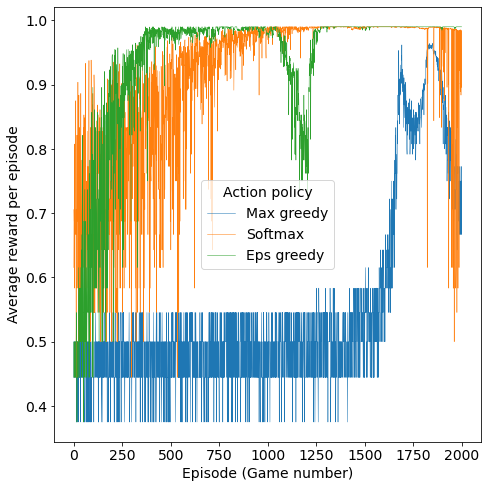

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(max_res[1], label = "Max greedy", linewidth = .5)
plt.plot(soft_res[1], label = "Softmax", linewidth = .5)
plt.plot(eps_res[1], label = 'Eps greedy', linewidth = .5)
plt.xlabel("Episode (Game number)")
plt.ylabel("Average reward per episode")
plt.legend(title = 'Action policy')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("plots/cart_pole_rewards.png",dpi = 300)
plt.show()

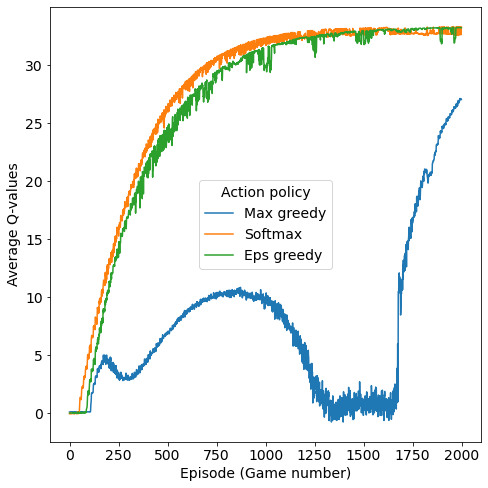

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(max_res[2], label = "Max greedy")
plt.plot(soft_res[2], label = "Softmax")
plt.plot(eps_res[2], label = 'Eps greedy')
plt.xlabel("Episode (Game number)")
plt.ylabel("Average Q-values")
plt.legend(title = 'Action policy')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("plots/cart_pole_qvals.png",dpi = 300)
plt.show()

# Tune Hyper-parameters

In [ ]:
# define the objective function
def objective(trial):

  # general parameters
  replay_memory_capacity = 10000 
  min_samples_for_training = 1000
  target_net_update_steps = 10   # Number of episodes to wait before updating the target network
  batch_size = 128   # Number of samples to take from the replay memory for each update

  # define the model
  policy_net = DQN(4,2)
  target_net = DQN(4, 2)
  target_net.load_state_dict(policy_net.state_dict())

  # Initialize the replay memory
  replay_mem = ReplayMemory(replay_memory_capacity)    

  # sample hyper-parameters
  lr = trial.suggest_float('lr',1e-4,1e-1, log = True)
  gamma = trial.suggest_float('gamma',0.8,1,log = True)
  #bad_state_penalty = trial.suggest_float('bad_trial_penalty',-1,0)
  pos_weight = trial.suggest_int('pos_weight',0,3)
  decay_speed = trial.suggest_int('decay_speed',3,6)

  ### Sample the loss function
  loss_fn_name = trial.suggest_categorical('optimiser_name',["SmoothL1Loss","MSELoss"])
  loss_fn = getattr(nn, loss_fn_name)()

  ### Initialize the optimizer
  sgd = torch.optim.SGD(policy_net.parameters(), lr = lr)

  ### Initialise exploration profiles
  eps_greedy = Exploration_profile(1,n_episodes,'eps_greedy', decay_speed = decay_speed)

  ### run training
  res = run_training(eps_greedy,policy_net,target_net,replay_mem,gamma,sgd,loss_fn,
                     batch_size,pos_weight)
  print('max score:', max(res[0]))
  # now create the report
  trial.report(np.mean(res[1]), np.mean(res[0]))
  
  return np.mean(res[1])

In [ ]:
torch.manual_seed(2909)
np.random.seed(2909)
# general parameters
n_episodes = 2000
replay_memory_capacity = 10000 
min_samples_for_training = 1000
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = -5
# define the study (i.e. the parameter serach study)
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

# define the number of trials
n_trials = 10

# run the study
study.optimize(objective, n_trials = n_trials)

best_trial = study.best_trial
print("Best prameters:")
for key, value in best_trial.params.items():
  print("\t{}: {}".format(key, value))

print("Highest average reward:")
print("\t {}".format(best_trial.value))

#save the best parameters
with open('models/best_trial.pickle', 'wb') as f:
        pickle.dump(best_trial, f, protocol=pickle.HIGHEST_PROTOCOL)


[I 2022-07-06 13:42:15,947] A new study created in memory with name: no-name-b459b986-368d-4790-8aeb-5e70ef8ea07c
100%|██████████| 2000/2000 [04:34<00:00,  7.29it/s]
[I 2022-07-06 13:46:50,556] Trial 0 finished with value: 0.7881317868049218 and parameters: {'lr': 0.0014807117857451684, 'gamma': 0.9898761345173257, 'pos_weight': 0, 'decay_speed': 3, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 0 with value: 0.7881317868049218.


max score: 215


100%|██████████| 2000/2000 [08:27<00:00,  3.94it/s]
[I 2022-07-06 13:55:18,232] Trial 1 finished with value: 0.8904015471814546 and parameters: {'lr': 0.07286849467243155, 'gamma': 0.8692631868210595, 'pos_weight': 0, 'decay_speed': 5, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 1 with value: 0.8904015471814546.


max score: 283


100%|██████████| 2000/2000 [03:15<00:00, 10.24it/s]
[I 2022-07-06 13:58:33,554] Trial 2 finished with value: 0.6703414308643978 and parameters: {'lr': 0.00031487835671822477, 'gamma': 0.9176101572878476, 'pos_weight': 2, 'decay_speed': 6, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 1 with value: 0.8904015471814546.


max score: 130


100%|██████████| 2000/2000 [19:04<00:00,  1.75it/s]
[I 2022-07-06 14:17:38,479] Trial 3 finished with value: 0.9209487570197956 and parameters: {'lr': 0.009836095127304269, 'gamma': 0.9787271076963473, 'pos_weight': 0, 'decay_speed': 4, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 3 with value: 0.9209487570197956.


max score: 500


100%|██████████| 2000/2000 [04:57<00:00,  6.73it/s]
[I 2022-07-06 14:22:35,692] Trial 4 finished with value: 0.7002746490838901 and parameters: {'lr': 0.0010083983054979433, 'gamma': 0.9676515710477422, 'pos_weight': 3, 'decay_speed': 4, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 3 with value: 0.9209487570197956.


max score: 368


100%|██████████| 2000/2000 [07:18<00:00,  4.56it/s]
[I 2022-07-06 14:29:54,788] Trial 5 finished with value: 0.5826883993611833 and parameters: {'lr': 0.011037947264551397, 'gamma': 0.8709857078001987, 'pos_weight': 3, 'decay_speed': 6, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 3 with value: 0.9209487570197956.


max score: 500


100%|██████████| 2000/2000 [06:10<00:00,  5.40it/s]
[I 2022-07-06 14:36:05,151] Trial 6 finished with value: 0.8917609025243405 and parameters: {'lr': 0.001220800639705491, 'gamma': 0.8393161357941981, 'pos_weight': 0, 'decay_speed': 4, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 3 with value: 0.9209487570197956.


max score: 208


100%|██████████| 2000/2000 [04:32<00:00,  7.34it/s]
[I 2022-07-06 14:40:37,938] Trial 7 finished with value: 0.7051167442352121 and parameters: {'lr': 0.0014742919612125754, 'gamma': 0.8145536836453428, 'pos_weight': 2, 'decay_speed': 5, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 3 with value: 0.9209487570197956.


max score: 496


100%|██████████| 2000/2000 [33:25<00:00,  1.00s/it]
[I 2022-07-06 15:14:03,608] Trial 8 finished with value: 0.6104022093986734 and parameters: {'lr': 0.00926675032548551, 'gamma': 0.9462752840584732, 'pos_weight': 3, 'decay_speed': 4, 'optimiser_name': 'MSELoss'}. Best is trial 3 with value: 0.9209487570197956.


max score: 500


100%|██████████| 2000/2000 [18:26<00:00,  1.81it/s]
[I 2022-07-06 15:32:30,524] Trial 9 finished with value: 0.9156396399393727 and parameters: {'lr': 0.014971534421176543, 'gamma': 0.8168857517205348, 'pos_weight': 0, 'decay_speed': 5, 'optimiser_name': 'SmoothL1Loss'}. Best is trial 3 with value: 0.9209487570197956.


max score: 500
Best prameters:
	lr: 0.009836095127304269
	gamma: 0.9787271076963473
	pos_weight: 0
	decay_speed: 4
	optimiser_name: SmoothL1Loss
Highest average reward:
	 0.9209487570197956


# Final model

In [ ]:
with open("models/best_trial.pickle", 'rb') as f:
  best_trial = pickle.load(f)

In [ ]:
best_params = best_trial.params

In [ ]:
best_params['optimiser_name']

'SmoothL1Loss'

In [ ]:
# Set random seeds
torch.manual_seed(2909)
np.random.seed(2909)
random.seed(2909)

### PARAMETERS
n_episodes = 2000
gamma = best_params['gamma']  # gamma parameter for the long term reward (dicount factor)
replay_memory_capacity = 10000   # Replay memory capacity (storage)
lr = best_params['lr']
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = -5   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(4, 2)

### Initialize the target network with the same weights of the policy network
target_net = DQN(4, 2)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
sgd = torch.optim.SGD(policy_net.parameters(), lr = lr)

### Initialize the loss function (Huber loss)
huber = nn.SmoothL1Loss()

### Initialise exploration profiles
eps_greedy = Exploration_profile(1,n_episodes,'eps_greedy', decay_speed = best_params['decay_speed'])
#soft = Exploration_profile(.8,n_episodes,'eps_greedy', decay_speed = best_params['decay_speed'])

### Run training
final_res = run_training(eps_greedy, policy_net, target_net, replay_mem, gamma, sgd, huber, batch_size, pos_weight = 1)

### save model and results
# save the trained policy and target network
torch.save(policy_net.state_dict(), 'models/cart_policy_net_final.pth')
torch.save(target_net.state_dict(), 'models/cart_target_net_final.pth')

with open('models/cart_results_final.pickle','wb') as f:
  pickle.dump(final_res, f, protocol=pickle.HIGHEST_PROTOCOL)


100%|██████████| 2000/2000 [35:04<00:00,  1.05s/it]


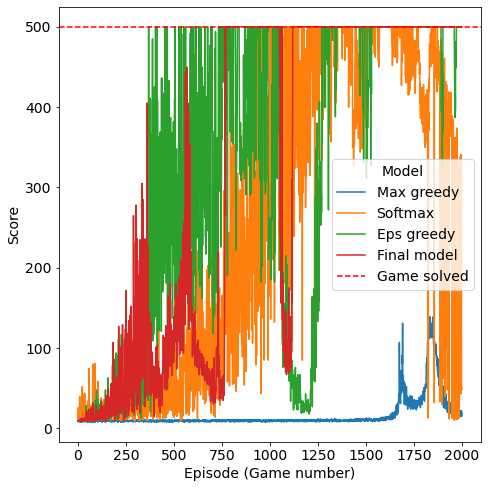

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(max_res[0], label = "Max greedy")
plt.plot(soft_res[0], label = "Softmax")
plt.plot(eps_res[0], label = 'Eps greedy')
plt.plot(final_res[0], label = 'Final model')
plt.axhline(y = 500, label = "Game solved", color = 'red', linestyle = 'dashed')
plt.xlabel("Episode (Game number)")
plt.ylabel("Score")
plt.legend(title = 'Model')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("plots/final_cart_pole_score.png",dpi = 300)
plt.show()

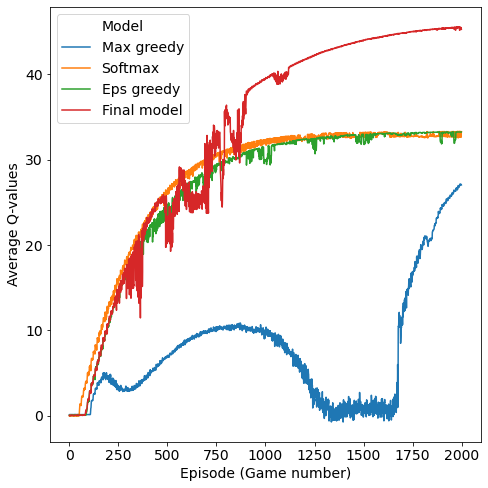

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(max_res[2], label = "Max greedy")
plt.plot(soft_res[2], label = "Softmax")
plt.plot(eps_res[2], label = 'Eps greedy')
plt.plot(final_res[2], label = 'Final model')
plt.xlabel("Episode (Game number)")
plt.ylabel("Average Q-values")
plt.legend(title = 'Model')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("plots/final_cart_pole_qvals.png",dpi = 300)
plt.show()

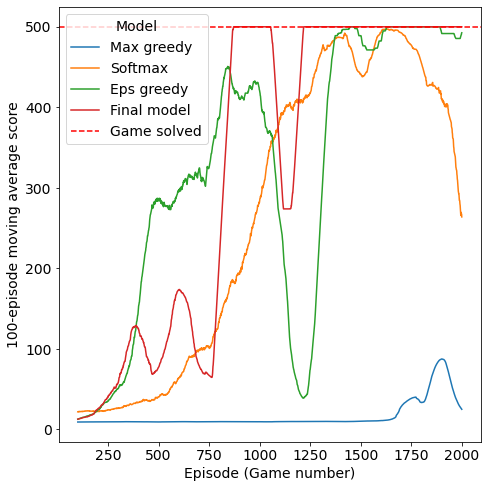

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(mvg_avg(max_res[0],100)[0],mvg_avg(max_res[0],100)[1], label = "Max greedy")
plt.plot(mvg_avg(soft_res[0],100)[0],mvg_avg(soft_res[0],100)[1], label = "Softmax")
plt.plot(mvg_avg(eps_res[0],100)[0],mvg_avg(eps_res[0],100)[1], label = "Eps greedy")
plt.plot(mvg_avg(final_res[0],100)[0],mvg_avg(final_res[0],100)[1], label = "Final model")
plt.axhline(y = 500, label = "Game solved", color = 'red', linestyle = 'dashed')
plt.xlabel("Episode (Game number)")
plt.ylabel("100-episode moving average score")
plt.legend(title = 'Model')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("plots/final_cart_pole_scores_avg.png",dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
# lets play the game using the final policy network
env = gym.make('CartPole-v1')
env.seed(2909) 
state = env.reset()

score = 0
frames = []
done = False
# Go on until the pole falls off or the score reach 490
while not done:
  # Choose the best action (temperature 0)
  action, q_values = choose_action_softmax(policy_net, state, temperature=0)
  # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
  next_state, reward, done, info = env.step(action)
  # Visually render the environment
  env.render()
  # Update the final score (+1 for each step)
  score += reward 
  # Set the current state for the next iteration
  state = next_state

  # save the visual
  frame = env.render(mode = 'rgb_array')
  frames.append(frame)


In [ ]:
import imageio
from IPython.display import Image
imageio.mimsave('plots/cart_final.gif', frames)
Image(open('plots/cart_final.gif','rb').read())

In [ ]:
if not os.path.isdir("plots/gifs/final_cart/"):
  os.makedirs("plots/gifs/final_cart/")
# store the final game stages
for i in range(len(frames)):
  plt.imshow(frames[i], cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  title = "Episode" + str(i)
  plt.title(title)
  plt.tight_layout()
  pth = "plots/gifs/final_cart/state_" + str(i) +".png"
  plt.savefig(pth, dpi = 300, bbox_inches='tight')
  plt.close()